## Setup

In [ ]:
!pip uninstall -y mediapipe protobuf

Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5


In [ ]:
!pip show protobuf

In [ ]:
pip install --upgrade grpcio-status ydf


INFO: pip is looking at multiple versions of ydf to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.72.1
    Uninstalling grpcio-1.72.1:
      Successfully uninstalled grpcio-1.72.1
  Attempting uninstall: ydf
    Found existing installation: ydf 0.12.0
    Uninstalling ydf-0.12.0:
      Successfully uninstalled ydf-0.12.0
  Attempting uninstall: grpcio-status
    Found existing installation: grpcio-status 1.71.0
    Uninstalling grpcio-status-1.71.0:
      Successfully uninstalled grpcio-status-1.71.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [ ]:
!pip install -q mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.73.0 requires protobuf<7.0.0,>=6.30.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.10.0 requires protobuf>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [ ]:
import cv2
from mediapipe.tasks.python.vision import HandLandmarkerResult

In [ ]:
from mediapipe.tasks.python.vision import PoseLandmarker, PoseLandmarkerOptions

In [ ]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
HandLandmarkerResult = mp.tasks.vision.HandLandmarkerResult
VisionRunningMode = mp.tasks.vision.RunningMode

In [ ]:
hand_options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    num_hands = 2
)
pose_options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='pose_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    output_segmentation_masks=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Test mediapipe

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

In [ ]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [ ]:
def draw_pose_landmarks(rgb_image, pose_result):
    annotated_image = np.copy(rgb_image)

    if not pose_result.pose_landmarks:
        return annotated_image

    pose_landmarks = pose_result.pose_landmarks[0]

    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    # Iterate over the landmarks of the first pose
    pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for lm in pose_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        annotated_image,
        pose_landmarks_proto,
        solutions.pose.POSE_CONNECTIONS,
        solutions.drawing_styles.get_default_pose_landmarks_style())

    return annotated_image

In [ ]:
cap = cv2.VideoCapture('/content/WIN_20250609_15_22_19_Pro.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ms_per_frame = int(1000/fps)
timestamp_ms = 0


29.89105969208607


In [ ]:
out = cv2.VideoWriter('output_with_landmarks.mp4',
                      cv2.VideoWriter_fourcc(*'mp4v'),
                      fps, (w, h))

In [ ]:
with HandLandmarker.create_from_options(hand_options) as hand_landmarker, \
     PoseLandmarker.create_from_options(pose_options) as pose_landmarker:

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            break
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
        hand_result: HandLandmarkerResult = hand_landmarker.detect_for_video(mp_image, timestamp_ms)
        pose_result = pose_landmarker.detect_for_video(mp_image, timestamp_ms)
        timestamp_ms += ms_per_frame
        annotated_frame = draw_pose_landmarks(rgb_frame, pose_result)
        annotated_frame = draw_landmarks_on_image(annotated_frame, hand_result)

        bgr_annotated = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        out.write(bgr_annotated)

cap.release()
out.release()


Ignoring empty camera frame.


## **Data preparation**

In [ ]:
import os
from glob import glob

In [ ]:
# !mkdir /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe

In [ ]:
# !rm -rf /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy

In [ ]:
root_dir = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe"
npy_dir = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy"
os.makedirs(npy_dir, exist_ok=True)

In [ ]:
def extract_landmarks_from_video(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Không thể mở video.")


        pose_detector = PoseLandmarker.create_from_options(pose_options)
        hand_detector = HandLandmarker.create_from_options(hand_options)

        pose_seq = []
        hand_seq = []
        frame_idx = 0

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)

            timestamp = frame_idx

            # Pose detection
            pose_result = pose_detector.detect_for_video(mp_image, timestamp)
            if pose_result.pose_landmarks:
                pose = np.array([[lm.x, lm.y, lm.z] for lm in pose_result.pose_landmarks[0]], dtype=np.float32)
            else:
                pose = np.zeros((33, 3), dtype=np.float32)
            pose_seq.append(pose)

            # Hand detection
            hand_result = hand_detector.detect_for_video(mp_image, timestamp)
            hands_frame = np.zeros((2, 21, 3), dtype=np.float32)
            for i, hand_landmarks in enumerate(hand_result.hand_landmarks[:2]):
                for j, lm in enumerate(hand_landmarks):
                    hands_frame[i, j] = [lm.x, lm.y, lm.z]
            hand_seq.append(hands_frame)

            frame_idx += 1

        cap.release()
        pose_seq = np.array(pose_seq)           # (T, 33, 3)
        hand_seq = np.array(hand_seq)           # (T, 2, 21, 3)

        combined = np.concatenate([
            pose_seq,                           # (T, 33, 3)
            hand_seq[:, 0],                     # Tay trái/phải 1
            hand_seq[:, 1]                      # Tay còn lại
        ], axis=1)                              # → (T, 75, 3)
        return combined

    except Exception as e:
        print(f"[ERROR] Failed to process {video_path}: {str(e)}")
        return None


In [ ]:
from tqdm.notebook import tqdm
video_paths = glob(os.path.join(root_dir, '*', 'rgb', '*avi'))
print(f"Found {len(video_paths)} video(s).")

for video_path in tqdm(video_paths, desc="Processing videos"):
    folder = video_path.split(os.sep)[-3]
    filename = os.path.splitext(os.path.basename(video_path))[0]
    landmark_path = os.path.join(npy_dir, folder, f"{filename}_landmarked.npy")

    os.makedirs(os.path.dirname(landmark_path), exist_ok=True)


    tqdm.write(f"Processing {video_path}...")
    landmarks = extract_landmarks_from_video(video_path)

    if landmarks is not None:
        np.save(landmark_path, landmarks)
        tqdm.write(f"Saved landmarks to {landmark_path}")
    else:
        tqdm.write(f"Skipped {video_path} due to error.")

Found 1014 video(s).


Processing videos:   0%|          | 0/1014 [00:00<?, ?it/s]

Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/298_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/298_A75P2__landmarked.npy
Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/225_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/225_A75P2__landmarked.npy
Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/517_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/517_A75P2__landmarked.npy
Processing /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe/A75P5/rgb/584_A75P2_.avi...
Saved landmarks to /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/584_A75P2__landmarked.npy
Processing /content/drive/MyDriv

## Keypoint Overlay

In [ ]:
import cv2
import numpy as np
import os

def visualize_on_video(video_path, npy_path, label, output_path,
                       radius=4, color=(0, 255, 0), thickness=-1, font_scale=1.0, font_color=(0, 0, 255)):
    # Load keypoints (T, N, 2)
    keypoints_seq = np.load(npy_path)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError(f"Không mở được video: {video_path}")

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if len(keypoints_seq) != frame_count:
        print(f"Cảnh báo: số frame trong video ({frame_count}) ≠ keypoints ({len(keypoints_seq)}) → dùng min(T)")
    T = min(len(keypoints_seq), frame_count)

    # Output writer
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    out_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

    for t in range(T):
        ret, frame = cap.read()
        if not ret:
            break

        keypoints = keypoints_seq[t]  # (N, 3)
        # Extract only the x and y coordinates
        keypoints_xy = keypoints[:, :2] # (N, 2)

        for x, y in keypoints_xy: # Iterate over (N, 2) array
            # Scale coordinates to image dimensions
            x = int(round(x * w))
            y = int(round(y * h))
            cv2.circle(frame, (x, y), radius, color, thickness)

        # Thêm nhãn vào góc trên trái
        cv2.putText(frame, f'Label: {label}', (20, 40),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=font_scale, color=font_color, thickness=2)

        out_writer.write(frame)

    cap.release()
    out_writer.release()
    print(f"Đã lưu video đã vẽ keypoints: {output_path}")

In [ ]:
video_path = '/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe'
npy_path = '/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy'

visualize_on_video(video_path, npy_path, label, output_path)


Đã lưu video đã vẽ keypoints: visualized/A75P1_video_vis.mp4


In [ ]:
from tqdm import tqdm
import zipfile
import os

def visualize_multiple_videos(data_list, output_dir, zip_output_path):
    os.makedirs(output_dir, exist_ok=True)
    output_paths = []

    print(f"🔧 Đang xử lý {len(data_list)} video...\n")

    for item in tqdm(data_list, desc="📂 Tổng tiến trình", unit="video"):
        video_path = item["video_path"]
        npy_path = item["npy_path"]
        label = item["label"]

        video_name = os.path.splitext(os.path.basename(video_path))[0]
        relative_folder = os.path.basename(os.path.dirname(os.path.dirname(video_path)))
        output_path = os.path.join(output_dir, f"{relative_folder}_{video_name}_visualized.mp4")

        # Tiến trình từng bước
        try:
            tqdm.write(f"\n📁 Đang xử lý: {video_name} (Label: {label})")

            tqdm.write("  📥 Đọc keypoints...")
            keypoints_seq = np.load(npy_path)

            tqdm.write("  📷 Mở video...")
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                tqdm.write(f"❌ Không mở được video: {video_path}")
                continue

            fps = cap.get(cv2.CAP_PROP_FPS)
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            T = min(len(keypoints_seq), frame_count)
            out_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

            frame_bar = tqdm(range(T), desc=f"  ✏️ Vẽ {video_name}", leave=False)
            for t in frame_bar:
                ret, frame = cap.read()
                if not ret:
                    break
                keypoints = keypoints_seq[t][:, :2]
                for x, y in keypoints:
                    x = int(round(x * w))
                    y = int(round(y * h))
                    cv2.circle(frame, (x, y), 4, (0, 255, 0), -1)
                cv2.putText(frame, f'Label: {label}', (20, 40),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=1.0, color=(0, 0, 255), thickness=2)
                out_writer.write(frame)

            cap.release()
            out_writer.release()
            output_paths.append(output_path)

        except Exception as e:
            tqdm.write(f"❌ Lỗi khi xử lý {video_path}: {e}")

    tqdm.write("\n📦 Đang nén các video đã xử lý...")
    with zipfile.ZipFile(zip_output_path, 'w') as zipf:
        for path in tqdm(output_paths, desc="🗜️ Nén", unit="file"):
            arcname = os.path.basename(path)
            zipf.write(path, arcname=arcname)

    tqdm.write(f"\n✅ Xong! File zip kết quả: {zip_output_path}")
    return zip_output_path

In [ ]:
import os

def build_data_list_with_custom_video_names(videos_root, keypoints_root):
    data_list = []

    for folder in os.listdir(videos_root):
        video_folder = os.path.join(videos_root, folder, 'rgb')
        keypoint_folder = os.path.join(keypoints_root, folder)

        if not os.path.isdir(video_folder) or not os.path.isdir(keypoint_folder):
            continue

        for file in os.listdir(video_folder):
            if not file.endswith(('.avi', '.mp4', '.mov')):
                continue

            video_path = os.path.join(video_folder, file)
            video_name = os.path.splitext(file)[0]  # bỏ đuôi .avi
            keypoint_name = f"{video_name}_landmarked.npy"
            keypoint_path = os.path.join(keypoint_folder, keypoint_name)

            if os.path.exists(keypoint_path):
                # Lấy label từ tên folder, ví dụ A51P1 → A51
                label = ''.join([c for c in folder if c.isalpha() or c.isdigit()]).rstrip('0123456789')

                data_list.append({
                    "video_path": video_path,
                    "npy_path": keypoint_path,
                    "label": label
                })
            else:
                print(f"[⚠️] Không tìm thấy keypoint cho video: {keypoint_path}")

    return data_list

In [ ]:
videos_root = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/mediapipe"            # nơi chứa video: dataset/A51P1/rgb/video.avi
keypoints_root = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy"       # nơi chứa landmark: landmarks/A51P1/video_landmark.npy

output_dir = "output_videos"
zip_path = "visualized_videos.zip"

data_list = build_data_list_with_custom_video_names(videos_root, keypoints_root)
zip_file = visualize_multiple_videos(data_list, output_dir, zip_path)

Đã lưu video đã vẽ keypoints: output_videos/298_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/225_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/517_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/584_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/406_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/457_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/31_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/156_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/350_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/99_A75P2__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/298_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/200_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/30_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/447_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_videos/398_A75P13__A75P.mp4
Đã lưu video đã vẽ keypoints: output_v

In [ ]:
video_dir = "videos"
keypoint_dir = "keypoints"
output_dir = "output_videos"
zip_output = "visualized_videos.zip"

data_list = build_data_list(video_dir, keypoint_dir)
zip_path = visualize_multiple_videos(data_list, output_dir, zip_output)

In [ ]:
from IPython.display import FileLink
FileLink(zip_path)

/content/visualized_videos.zip

In [ ]:
# prompt: .npy files sumaries, give a exercise by code
import glob
import os
from tqdm.notebook import tqdm
import numpy as np
# Task: Provide a summary of the shape and data type for all .npy files found
# within the specified npy_dir.

npy_dir = "/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy"
npy_files = glob.glob(os.path.join(npy_dir, '*', '*.npy'))

print(f"Found {len(npy_files)} .npy files.")

for npy_file in tqdm(npy_files, desc="Summarizing .npy files"):
    try:
        data = np.load(npy_file)
        tqdm.write(f"File: {npy_file}")
        tqdm.write(f"  Shape: {data.shape}")
        tqdm.write(f"  Data Type: {data.dtype}")
    except Exception as e:
        tqdm.write(f"Error processing {npy_file}: {e}")



Found 2759 .npy files.


Summarizing .npy files:   0%|          | 0/2759 [00:00<?, ?it/s]

File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/298_A75P2__landmarked.npy
  Shape: (51, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/225_A75P2__landmarked.npy
  Shape: (72, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/517_A75P2__landmarked.npy
  Shape: (66, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/584_A75P2__landmarked.npy
  Shape: (53, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/406_A75P2__landmarked.npy
  Shape: (50, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/457_A75P2__landmarked.npy
  Shape: (59, 75, 3)
  Data Type: float32
File: /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75

KeyboardInterrupt: 

In [ ]:
import numpy as np
max_frame_number = 0

for npy_file in tqdm(npy_files, desc="Finding maximum frame number"):
    try:
        data = np.load(npy_file)
        if data.shape[0] > max_frame_number:
            max_frame_number = data.shape[0]
            tqdm.write(f"New maximum found: {max_frame_number} in file {npy_file}")
    except Exception as e:
        tqdm.write(f"Error processing {npy_file}: {e}")

print(f"\nMaximum frame number found across all .npy files: {max_frame_number}")


Finding maximum frame number:   0%|          | 0/2759 [00:00<?, ?it/s]

New maximum found: 51 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/298_A75P2__landmarked.npy
New maximum found: 72 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P5/225_A75P2__landmarked.npy
New maximum found: 73 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P21/30_A75P13__landmarked.npy
New maximum found: 76 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A52P6/968_A52P8__landmarked.npy
New maximum found: 90 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A52P6/452_A52P8__landmarked.npy
New maximum found: 101 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A52P6/180_A52P8__landmarked.npy
New maximum found: 118 in file /content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/npy/A75P12/597_A75P17__landmarked.npy
New maximum found: 147 in file /content/drive/MyDr

## Model

In [2]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from tqdm import tqdm

In [3]:
def compute_global_stats(csv_file, max_frames=180):
    data = pd.read_csv(csv_file)
    x = []
    y = []
    for npy_path in tqdm(data['file_path'], desc="Computing global stats (CPU)"):
        data_np = np.load(npy_path)
        if data_np.shape[0] > max_frames:
            data_np = data_np[:max_frames]
        x.append(data_np[:, :, 0].flatten())
        y.append(data_np[:, :, 1].flatten())
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    w = x.max() - x.min() + 1e-6
    h = y.max() - y.min() + 1e-6
    x_min = x.min()
    y_min = y.min()
    return {'w': w, 'h': h, 'x_min': x_min, 'y_min': y_min}

In [4]:
import cupy as cp

def compute_global_stats_cupy(csv_file, max_frames=180):
    data = pd.read_csv(csv_file)
    x_list = []
    y_list = []
    for npy_path in tqdm(data['file_path'], desc="Computing global stats (GPU)"):
        data_np = np.load(npy_path)
        if data_np.shape[0] > max_frames:
            data_np = data_np[:max_frames]
        data_cp = cp.asarray(data_np)
        x_list.append(data_cp[:, :, 0].ravel())
        y_list.append(data_cp[:, :, 1].ravel())
    x = cp.concatenate(x_list)
    y = cp.concatenate(y_list)
    w = (x.max() - x.min() + 1e-6).item()
    h = (y.max() - y.min() + 1e-6).item()
    x_min = x.min().item()
    y_min = y.min().item()
    return {'w': w, 'h': h, 'x_min': x_min, 'y_min': y_min}

In [5]:
def compute_class_weights(data):
    labels = data['label'].values
    class_counts = np.bincount(labels, minlength=15)
    total_samples = len(labels)
    class_weights = total_samples / (15 * (class_counts+ 1e-5))
    return torch.tensor(class_weights, dtype=torch.float32)

In [6]:
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file, max_frames=180, stats =None, training=False):
        self.data = pd.read_csv(csv_file)
        self.max_frames = max_frames
        self.stats = stats
        self.training = training
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        row = self.data.iloc[index]
        label = row['label']
        npy_path = row['file_path']

        data = np.load(npy_path)

        seq_len = data.shape[0]

        if seq_len> self.max_frames:
            data = data[:self.max_frames]

        if self.stats is not None:
            data_normalized = data.copy()
            data_normalized[:,:,0] = (data[:,:,0] - self.stats['x_min'])/self.stats['w']
            data_normalized[:,:,1] = (data[:,:,1] - self.stats['y_min'])/self.stats['h']
            data_normalized[:,:,2] = data[:,:,2]
        else:
            data_normalized = data

        # data_reshaped = data.reshape(self.max_frames, -1)
        # data_normalized = data_normalized.reshape(self.max_frames, 75 * 3)
        # data_normalized = data_normalized.reshape(self.max_frames, 75*3)

        return torch.tensor(data_normalized, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(seq_len, dtype=torch.long)


In [7]:
def collate_fn(batch):
    data, labels, seq_lens = zip(*batch)
    data_repeated = []
    max_frames = 180
    for seq in data:
        seq_len =seq.size(0)
        if seq_len < max_frames:
            repeat_times = (max_frames + seq_len - 1) // seq_len
            seq_repeated = seq.repeat(repeat_times, 1, 1)[:max_frames]
        else:
            seq_repeated = seq[:max_frames]
        data_repeated.append(seq_repeated)
    data = torch.stack(data_repeated)
    data = data.view(data.size(0), data.size(1), -1)
    labels = torch.tensor(labels)
    seq_lens = torch.tensor(seq_lens)
    return data, labels, seq_lens

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden, encoder_outputs):

        batch_size, seq_len, _ = encoder_outputs.size()

        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, max_frames, hidden_size)

        energy = self.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, max_frames, hidden_size)
        energy = torch.sum(self.v * energy, dim=2)  # (batch_size, max_frames)

        attn_weights = self.softmax(energy)  # (batch_size, max_frames)

        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_size)

        return context, attn_weights


In [ ]:
# class SignLanguageLSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(SignLanguageLSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
#         self.attention = Attention(hidden_size)
#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, x, seq_lens):

#         seq_lens, perm_idx = seq_lens.sort(0, descending=True)
#         x = x[perm_idx]

#         packed_input = pack_padded_sequence(x, seq_lens, batch_first=True, enforce_sorted=True)
#         packed_output, (hn, cn) = self.lstm(packed_input)

#         output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)  # (batch_size, max_frames, hidden_size)

#         hidden = hn[-1]  # (batch_size, hidden_size)

#         context, attn_weights = self.attention(hidden, output)

#         out = self.dropout(context)
#         out = self.fc(out)
#         return out

In [42]:
class SignLanguageLSTM(nn.Module):
    def __init__(self, input_size,num_classes = 15):
        super(SignLanguageLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = 512, batch_first=True, bidirectional = False)
        self.lstm2 = nn.LSTM(input_size = 512, hidden_size = 1024, batch_first=True, bidirectional = False)
        self.lstm3 = nn.LSTM(input_size=1024, hidden_size=512, batch_first=True, bidirectional=False)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True, bidirectional=False)
        self.lstm5 = nn.LSTM(input_size=512, hidden_size=512, batch_first=True, bidirectional=False)
        self.lstm6 = nn.LSTM(input_size=512, hidden_size=512, batch_first=True, bidirectional=False)
        self.lstm7 = nn.LSTM(input_size=512, hidden_size=512, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, seq_lens):
        B, T, _ = x.shape
        seq_lens_cpu = seq_lens.cpu().long()
        seq_lens_sorted, perm_idx = seq_lens_cpu.sort(0, descending=True)
        x = x[perm_idx]

        packed = pack_padded_sequence(x, seq_lens_sorted, batch_first=True, enforce_sorted=True)
        packed, _ = self.lstm1(packed)
        packed, _ = self.lstm2(packed)
        packed, _ = self.lstm3(packed)
        packed, _ = self.lstm4(packed)
        packed, _ = self.lstm5(packed)
        packed, _ = self.lstm6(packed)
        packed, _ = self.lstm7(packed)

        unpacked, _ = pad_packed_sequence(packed, batch_first=True)

        last_outputs = unpacked[torch.arange(unpacked.size(0)), seq_lens_sorted - 1]

        _, unperm_idx = perm_idx.sort(0)
        last_outputs = last_outputs[unperm_idx]


        x = F.relu(self.fc1(last_outputs))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [30]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    class_weights = compute_class_weights(train_loader.dataset.data).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    best_val_loss = float('inf')
    train_metrics = {'loss': [], 'acc': []}
    val_metrics = {'loss': [], 'acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
        for data, labels, seq_lens in train_bar:
            data, labels, seq_lens = data.to(device), labels.to(device), seq_lens.to(device)
            optimizer.zero_grad()
            outputs = model(data, seq_lens)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20)
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_bar.set_postfix({'Train Loss': train_loss / (train_bar.n + 1), 'Train Acc': 100 * train_correct / train_total})

        train_acc = 100 * train_correct / train_total
        train_metrics['loss'].append(train_loss / len(train_loader))
        train_metrics['acc'].append(train_acc)

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)
        with torch.no_grad():
            for data, labels, seq_lens in val_bar:
                data, labels, seq_lens = data.to(device), labels.to(device), seq_lens.to(device)
                outputs = model(data, seq_lens)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_bar.set_postfix({'Val Loss': val_loss / (val_bar.n + 1), 'Val Acc': 100 * val_correct / val_total})

        val_acc = 100 * val_correct / val_total
        val_metrics['loss'].append(val_loss / len(val_loader))
        val_metrics['acc'].append(val_acc)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f} seconds')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_metrics['loss'], label='Train Loss')
    plt.plot(val_metrics['loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_metrics['acc'], label='Train Acc')
    plt.plot(val_metrics['acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

    return train_metrics, val_metrics


In [32]:
def evaluate_model(model, val_loader, device='cuda' if torch.cuda.is_available() else 'cpu', plot_cm=False):
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, labels, seq_lens in tqdm(val_loader, desc='Evaluating', leave=False):
            data, labels, seq_lens = data.to(device), labels.to(device), seq_lens.to(device)
            outputs = model(data, seq_lens)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Validation Accuracy: {accuracy:.2f}%')
    print(f'Validation F1-Score: {f1:.4f}')

    if plot_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(15), yticklabels=range(15))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, f1

Computing global scaler...


Computing global stats (CPU): 100%|██████████| 2207/2207 [00:04<00:00, 494.04it/s]


Total parameters: 14156367


Epoch 1/50, Train Loss: 2.4829, Train Acc: 6.25%, Val Loss: 3.0325, Val Acc: 0.91%, Time: 4.66 seconds


Epoch 2/50, Train Loss: 2.2391, Train Acc: 6.80%, Val Loss: 2.9522, Val Acc: 0.91%, Time: 4.95 seconds


Epoch 3/50, Train Loss: 2.2698, Train Acc: 6.30%, Val Loss: 2.9325, Val Acc: 0.91%, Time: 4.86 seconds


Epoch 4/50, Train Loss: 2.1541, Train Acc: 7.39%, Val Loss: 2.9559, Val Acc: 0.91%, Time: 4.88 seconds


Epoch 5/50, Train Loss: 2.2360, Train Acc: 6.30%, Val Loss: 2.9735, Val Acc: 0.91%, Time: 4.72 seconds


Epoch 6/50, Train Loss: 2.2075, Train Acc: 6.62%, Val Loss: 3.0063, Val Acc: 0.91%, Time: 4.65 seconds


Epoch 7/50, Train Loss: 2.1290, Train Acc: 7.70%, Val Loss: 3.0876, Val Acc: 0.91%, Time: 4.75 seconds


Epoch 8/50, Train Loss: 2.2672, Train Acc: 6.43%, Val Loss: 2.9760, Val Acc: 0.91%, Time: 4.90 seconds


Epoch 9/50, Train Loss: 2.2051, Train Acc: 6.66%, Val Loss: 2.9942, Val Acc: 0.91%, Time: 4.73 seconds


Epoch 10/50, Train Loss: 2.1350, Train Acc: 7.48%, Val Loss: 3.0224, Val Acc: 0.91%, Time: 4.71 seconds


Epoch 11/50, Train Loss: 2.1616, Train Acc: 7.39%, Val Loss: 2.9396, Val Acc: 0.91%, Time: 4.76 seconds


Epoch 12/50, Train Loss: 2.1178, Train Acc: 7.70%, Val Loss: 3.0645, Val Acc: 0.91%, Time: 4.82 seconds


Epoch 13/50, Train Loss: 2.1207, Train Acc: 7.93%, Val Loss: 3.0202, Val Acc: 0.91%, Time: 4.66 seconds


Epoch 14/50, Train Loss: 2.2525, Train Acc: 6.16%, Val Loss: 2.9446, Val Acc: 0.91%, Time: 4.71 seconds


Epoch 15/50, Train Loss: 2.2266, Train Acc: 6.48%, Val Loss: 2.9667, Val Acc: 0.91%, Time: 4.76 seconds


Epoch 16/50, Train Loss: 2.1665, Train Acc: 7.34%, Val Loss: 3.0116, Val Acc: 0.91%, Time: 4.54 seconds


Epoch 17/50, Train Loss: 2.1493, Train Acc: 7.43%, Val Loss: 2.9719, Val Acc: 0.91%, Time: 4.68 seconds


Epoch 18/50, Train Loss: 2.2898, Train Acc: 5.89%, Val Loss: 2.9123, Val Acc: 0.91%, Time: 4.57 seconds


Epoch 19/50, Train Loss: 2.2348, Train Acc: 6.84%, Val Loss: 2.9771, Val Acc: 0.91%, Time: 4.62 seconds


Epoch 20/50, Train Loss: 2.2107, Train Acc: 6.71%, Val Loss: 2.9389, Val Acc: 0.91%, Time: 4.70 seconds


Epoch 21/50, Train Loss: 2.1763, Train Acc: 7.43%, Val Loss: 3.0558, Val Acc: 0.91%, Time: 4.69 seconds


Epoch 22/50, Train Loss: 2.1738, Train Acc: 6.75%, Val Loss: 2.9718, Val Acc: 0.91%, Time: 4.70 seconds


Epoch 23/50, Train Loss: 2.2600, Train Acc: 6.30%, Val Loss: 2.9453, Val Acc: 0.91%, Time: 4.72 seconds


Epoch 24/50, Train Loss: 2.2093, Train Acc: 6.71%, Val Loss: 3.0080, Val Acc: 0.91%, Time: 4.75 seconds


Epoch 25/50, Train Loss: 2.2029, Train Acc: 6.80%, Val Loss: 2.9386, Val Acc: 0.91%, Time: 4.70 seconds


Epoch 26/50, Train Loss: 2.1635, Train Acc: 7.07%, Val Loss: 3.0594, Val Acc: 0.91%, Time: 4.70 seconds


Epoch 27/50, Train Loss: 2.2222, Train Acc: 6.71%, Val Loss: 2.9338, Val Acc: 0.91%, Time: 4.88 seconds


Epoch 28/50, Train Loss: 2.1384, Train Acc: 7.34%, Val Loss: 3.0230, Val Acc: 0.91%, Time: 4.79 seconds


Epoch 29/50, Train Loss: 2.2284, Train Acc: 6.71%, Val Loss: 2.9952, Val Acc: 0.91%, Time: 4.59 seconds


Epoch 30/50, Train Loss: 2.2520, Train Acc: 6.21%, Val Loss: 2.9139, Val Acc: 0.91%, Time: 4.80 seconds


Epoch 31/50, Train Loss: 2.2745, Train Acc: 6.03%, Val Loss: 2.9328, Val Acc: 0.91%, Time: 4.66 seconds


Epoch 32/50, Train Loss: 2.2348, Train Acc: 6.39%, Val Loss: 2.9995, Val Acc: 0.91%, Time: 4.68 seconds


Epoch 33/50, Train Loss: 2.2595, Train Acc: 6.12%, Val Loss: 2.9470, Val Acc: 0.91%, Time: 4.76 seconds


Epoch 34/50, Train Loss: 2.1995, Train Acc: 6.43%, Val Loss: 2.9966, Val Acc: 0.91%, Time: 4.67 seconds


Epoch 35/50, Train Loss: 2.2659, Train Acc: 6.03%, Val Loss: 2.9603, Val Acc: 0.91%, Time: 4.83 seconds


Epoch 36/50, Train Loss: 2.1950, Train Acc: 6.71%, Val Loss: 2.9849, Val Acc: 0.91%, Time: 4.67 seconds


Epoch 37/50, Train Loss: 2.2735, Train Acc: 6.03%, Val Loss: 2.9341, Val Acc: 0.91%, Time: 4.58 seconds


Epoch 38/50, Train Loss: 2.1489, Train Acc: 7.43%, Val Loss: 3.0602, Val Acc: 0.91%, Time: 4.73 seconds


Epoch 39/50, Train Loss: 2.2080, Train Acc: 6.66%, Val Loss: 2.9395, Val Acc: 0.91%, Time: 4.58 seconds


Epoch 40/50, Train Loss: 2.2360, Train Acc: 6.66%, Val Loss: 2.9821, Val Acc: 0.91%, Time: 4.55 seconds


Epoch 41/50, Train Loss: 2.1017, Train Acc: 7.88%, Val Loss: 3.0545, Val Acc: 0.91%, Time: 4.76 seconds


Epoch 42/50, Train Loss: 2.2257, Train Acc: 6.52%, Val Loss: 2.9571, Val Acc: 0.91%, Time: 4.68 seconds


Epoch 43/50, Train Loss: 2.2691, Train Acc: 6.03%, Val Loss: 2.9197, Val Acc: 0.91%, Time: 4.78 seconds


Epoch 44/50, Train Loss: 2.1204, Train Acc: 7.70%, Val Loss: 3.0227, Val Acc: 0.91%, Time: 4.63 seconds


Epoch 45/50, Train Loss: 2.1905, Train Acc: 6.93%, Val Loss: 2.9805, Val Acc: 0.91%, Time: 4.72 seconds


Epoch 46/50, Train Loss: 2.1740, Train Acc: 7.11%, Val Loss: 2.9985, Val Acc: 0.91%, Time: 4.78 seconds


Epoch 47/50, Train Loss: 2.1474, Train Acc: 7.16%, Val Loss: 3.0389, Val Acc: 0.91%, Time: 4.61 seconds


Epoch 48/50, Train Loss: 2.1595, Train Acc: 7.16%, Val Loss: 2.9759, Val Acc: 0.91%, Time: 4.69 seconds


Epoch 49/50, Train Loss: 2.1890, Train Acc: 7.16%, Val Loss: 2.9720, Val Acc: 0.91%, Time: 4.73 seconds


Epoch 50/50, Train Loss: 2.2482, Train Acc: 6.39%, Val Loss: 2.9672, Val Acc: 0.91%, Time: 4.66 seconds


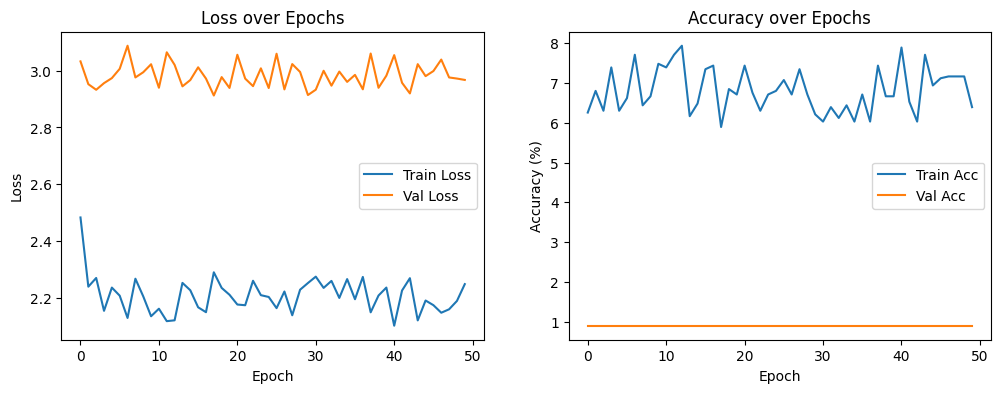

Validation Accuracy: 0.91%
Validation F1-Score: 0.0002


NameError: name 'confusion_matrix' is not defined

In [44]:
train_csv = '/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/train.corpus.csv'
val_csv = '/content/drive/MyDrive/SlowFastSign-main/dataset/vietnamsignlanguage/valid.corpus.csv'
max_frames = 180
input_size = 75 * 3
# hidden_size = 256
# num_layers = 10
num_classes = 15
batch_size = 64

print("Computing global scaler...")
scaler = compute_global_stats(train_csv, max_frames)

train_dataset = SignLanguageDataset(train_csv, max_frames, scaler, training=True)
val_dataset = SignLanguageDataset(val_csv, max_frames, scaler, training=False)

train_labels = train_dataset.data['label'].values
class_counts = np.bincount(train_labels, minlength=15)
sample_weights = 1.0 / class_counts[train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=4)

model = SignLanguageLSTM(input_size, num_classes)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")

train_metrics, val_metrics = train_model(model, train_loader, val_loader)
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, val_loader, plot_cm=True)

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, val_loader)

Validation Accuracy: 6.70%
Validation F1-Score: 0.0084


(6.702898550724638, 0.008421298688516522)